In [ ]:
import torch
import torch.nn as nn
import numpy as np
import librosa
import soundfile as sf # Dùng để lưu file audio


class CasualMHSA(nn.Module):
    def __init__(self, d_model, n_head, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, n_head, dropout=dropout, batch_first=True)
    def forward(self, x):
        B, T, D = x.shape
        attn_mask = torch.triu(torch.ones(T, T, device=x.device) * float('-inf'), diagonal=1)
        x_out, _ = self.mha(x, x, x, attn_mask=attn_mask)
        return x_out

class ConformerConvModule(nn.Module):
    def __init__(self, d_model, kernel_size=15, dropout=0.1):
        super().__init__()
        self.pointwise_conv1 = nn.Conv1d(d_model, d_model * 2, kernel_size=1)
        self.glu = nn.GLU(dim=1)
        self.depthwise_conv = nn.Conv1d(d_model, d_model, kernel_size, padding=(kernel_size-1)//2, groups=d_model)
        self.batch_norm = nn.GroupNorm(num_groups=1, num_channels=d_model)
        self.activation = nn.SiLU()
        self.pointwise_conv2 = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.dropout(self.pointwise_conv2(self.activation(self.batch_norm(self.depthwise_conv(self.glu(self.pointwise_conv1(x)))))))
        return x.transpose(1, 2)

class FeedForwardModule(nn.Module):
    def __init__(self, d_model, expansion_factor=4, dropout=0.1):
        super().__init__()
        self.layer1 = nn.Linear(d_model, d_model*expansion_factor)
        self.activation = nn.SiLU()
        self.dropout1 = nn.Dropout(dropout)
        self.layer2 = nn.Linear(d_model*expansion_factor, d_model)
        self.dropout2 = nn.Dropout(dropout)
    def forward(self, x):
        return self.dropout2(self.layer2(self.dropout1(self.activation(self.layer1(x)))))

class ConformerBlock(nn.Module):
    def __init__(self, d_model, n_head, kernel_size=15, dropout=0.1):
        super().__init__()
        self.ffn1 = FeedForwardModule(d_model, dropout=dropout)
        self.conv_module = ConformerConvModule(d_model, kernel_size=kernel_size, dropout=dropout)
        self.self_attn = CasualMHSA(d_model, n_head, dropout=dropout)
        self.ffn2 = FeedForwardModule(d_model, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model); self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model); self.norm4 = nn.LayerNorm(d_model)
        self.final_norm = nn.LayerNorm(d_model)
    def forward(self, x):
        x = x + 0.5 * self.ffn1(self.norm1(x))
        x = x + self.conv_module(self.norm2(x))
        x = x + self.self_attn(self.norm3(x))
        x = x + 0.5 * self.ffn2(self.norm4(x))
        return self.final_norm(x)

class AEC(nn.Module):
    def __init__(self, d_model=128, n_fft=512, n_head=8, num_layers=4, kernel_size=15):
        super().__init__()
        self.n_fft = n_fft
        self.n_freq = n_fft // 2 + 1
        input_dim = self.n_freq * 4
        self.input_proj = nn.Linear(input_dim, d_model)
        self.layers = nn.ModuleList([
            ConformerBlock(d_model, n_head, kernel_size=kernel_size)
            for _ in range(num_layers)
        ])
        self.mask_proj = nn.Linear(d_model, self.n_freq * 2)
        self.vad_proj = nn.Linear(d_model, 2)
    def forward(self, mic_stft, ref_stft):
        B, F, T, C = mic_stft.shape
        mic_flat = mic_stft.permute(0, 2, 1, 3).reshape(B, T, F * 2)
        ref_flat = ref_stft.permute(0, 2, 1, 3).reshape(B, T, F * 2)
        x = torch.cat([mic_flat, ref_flat], dim=2)
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x)
        mask = self.mask_proj(x)
        mask = mask.view(B, T, F, 2).permute(0, 2, 1, 3)
        mic_real, mic_imag = mic_stft[..., 0], mic_stft[..., 1]
        mask_real, mask_imag = mask[..., 0], mask[..., 1]
        est_real = mic_real * mask_real - mic_imag * mask_imag
        est_imag = mic_real * mask_imag + mic_imag * mask_real
        vad_logits = self.vad_proj(x)
        return torch.stack([est_real, est_imag], dim=-1)

# --- Các hàm hỗ trợ xử lý tín hiệu ---

def run_inference(model_path, mic_path, ref_path, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Load Model
    model = AEC(d_model=128, n_fft=512).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # 2. Load Audio bằng Librosa
    y_mic, _ = librosa.load(mic_path, sr=16000)
    y_ref, _ = librosa.load(ref_path, sr=16000)

    # --- SỬA LỖI TẠI ĐÂY: Căn chỉnh độ dài ---
    min_len = min(len(y_mic), len(y_ref))
    y_mic = y_mic[:min_len]
    y_ref = y_ref[:min_len]
    # ---------------------------------------
    
    # 3. Chuẩn bị STFT
    n_fft, hop_length, win_length = 512, 160, 320
    window = torch.hann_window(win_length).to(device)
    
    def to_stft(y):
        y_torch = torch.from_numpy(y).float().to(device)
        stft_complex = torch.stft(y_torch, n_fft=n_fft, hop_length=hop_length, 
                                  win_length=win_length, window=window, 
                                  center=True, return_complex=True)
        return torch.view_as_real(stft_complex).unsqueeze(0) # (1, F, T, 2)

    mic_stft = to_stft(y_mic)
    ref_stft = to_stft(y_ref)

    # 4. Forward qua model
    with torch.no_grad():
        # Bây giờ mic_stft và ref_stft chắc chắn có cùng số khung T
        est_stft = model(mic_stft, ref_stft)

    # 5. Inverse STFT để về miền thời gian
    est_complex = torch.complex(est_stft[..., 0], est_stft[..., 1]).squeeze(0)
    y_est = torch.istft(est_complex, n_fft=n_fft, hop_length=hop_length, 
                        win_length=win_length, window=window, center=True)
    
    # 6. Lưu kết quả
    output_audio = y_est.cpu().numpy()
    sf.write(save_path, output_audio, 16000)
    print(f"--- Đã lưu file kết quả tại: {save_path} ---")

if __name__ == "__main__":
    MODEL_FILE = "aec_v2_step_2900.pth" # Thay bằng file của bạn
    MIC_FILE = "cut_audio/0000_mic.flac"
    REF_FILE = "cut_audio/0000_ref.flac"
    SAVE_FILE = "cut_audio/out_cut.wav"
    
    run_inference(MODEL_FILE, MIC_FILE, REF_FILE, SAVE_FILE)

--- Đã lưu file kết quả tại: cut_audio/out_cut.wav ---


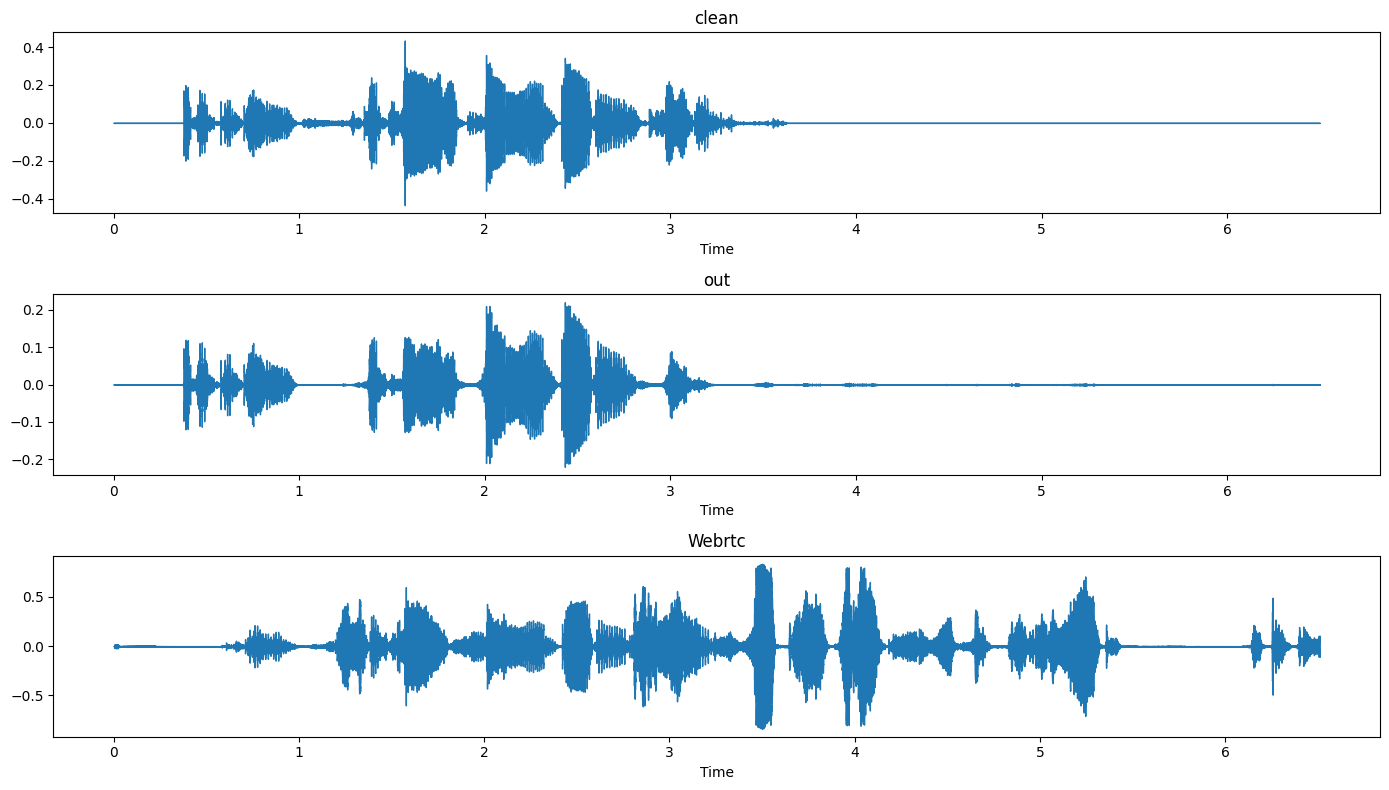

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
file1 = "cut_audio/000_clean.flac"
file2 = "cut_audio/out_cut.wav"
file3 = "cut_audio/0000_mic_out.wav"

# Load audio
y1, sr1 = librosa.load(file1, sr=None)
y2, sr2 = librosa.load(file2, sr=None)
y3, _ = librosa.load(file3,sr=16000)
# STFT parameters
n_fft = 512
win_length = 320
hop_length = 160

# Compute STFT

# Convert to dB
# Plot
plt.figure(figsize=(14, 8))

# -------- Audio 1 --------
plt.subplot(3, 1, 1)
librosa.display.waveshow(y1, sr=sr1)
plt.title("clean")

plt.subplot(3, 1, 2)
librosa.display.waveshow(y2, sr=sr1)
plt.title("out")

# -------- Audio 2 --------
plt.subplot(3, 1, 3)
librosa.display.waveshow(y3, sr=sr2)
plt.title("Webrtc")

plt.tight_layout()
plt.show()